<a href="https://colab.research.google.com/github/Nanungi/intermediate-ML/blob/main/project_core_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier



# Setting options
n=800
pd.set_option('display.max_columns',n)
pd.set_option("display.max_info_rows", n)
pd.set_option('display.max_info_columns',n)
from sklearn import set_config
set_config(transform_output='pandas')

In [3]:
#custom function.
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict


def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    # Get predictions for training data
    y_train_pred = model.predict(X_train)
    # Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = model.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
    if output_dict == True:
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict

In [4]:
#loading data
file='/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week17/Data/Metabolic  Syndrome (1).csv'
df=pd.read_csv(file)
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


In [5]:
#data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   seqn               int64  
 1   Age                int64  
 2   Sex                object 
 3   Marital            object 
 4   Income             float64
 5   Race               object 
 6   WaistCirc          float64
 7   BMI                float64
 8   Albuminuria        int64  
 9   UrAlbCr            float64
 10  UricAcid           float64
 11  BloodGlucose       int64  
 12  HDL                int64  
 13  Triglycerides      int64  
 14  MetabolicSyndrome  object 
dtypes: float64(5), int64(6), object(4)
memory usage: 281.5+ KB


In [6]:
#summary statistics
df.describe()

,seqn,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
count,2401.000000,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,67030.674302,48.691795,4005.253940,98.307254,28.702189,0.154102,43.626131,5.489046,108.247813,53.369429,128.125364
std,2823.565114,17.632852,2954.032186,16.252634,6.662242,0.422780,258.272829,1.439358,34.820657,15.185537,95.322477
min,62161.000000,20.000000,300.000000,56.200000,13.400000,0.000000,1.400000,1.800000,39.000000,14.000000,26.000000
25%,64591.000000,34.000000,1600.000000,86.675000,24.000000,0.000000,4.450000,4.500000,92.000000,43.000000,75.000000
50%,67059.000000,48.000000,2500.000000,97.000000,27.700000,0.000000,7.070000,5.400000,99.000000,51.000000,103.000000
75%,69495.000000,63.000000,6200.000000,107.625000,32.100000,0.000000,13.690000,6.400000,110.000000,62.000000,150.000000
max,71915.000000,80.000000,9000.000000,176.000000,68.700000,2.000000,5928.000000,11.300000,382.000000,156.000000,1562.000000


In [7]:
#duplicate rows
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

#metabolic syndrome being our target we will turn it into numeric and one hot encode the rest of the object data types.

#missing values are going to be imputed with 0



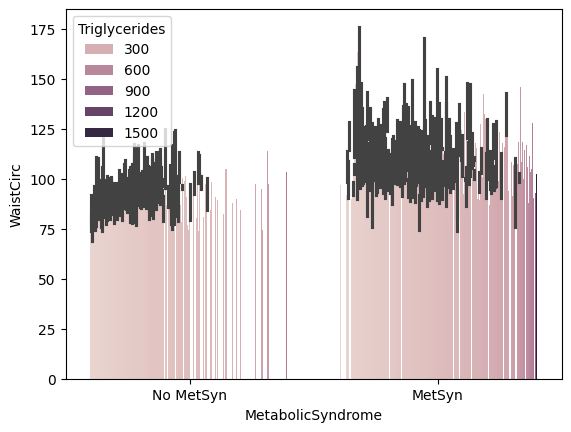

In [8]:
#exploratory data viz
#using a barplot to understand the data and search for trends between the numeric and categorical features.
# Using seaborn to plot the group means by waistcircumference colored by tryglycerides

ax = sns.barplot(data=df, x="MetabolicSyndrome", y="WaistCirc", hue='Triglycerides')



#in the metabolic syndrome batch we notice that they have a higher values of waist circumference and a slightly deeper hue of the triglycerides compared to the non metabolic syndrome batch.

In [56]:
# Drop irrelevant and high cardinality features
cols_drop = ['BMI', 'UricAcid','Albuminuria']
# Create features matrix and target vector
X = df.drop(columns = [ 'MetabolicSyndrome'])
y = df['MetabolicSyndrome']
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)



In [57]:
# Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "0")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
# Numerical Preprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple],
                                 verbose_feature_names_out=False)
# fit the column transformer on X_train
preprocessor.fit(X_train)
# Transform X_train and X_test
X_train_tf = preprocessor.transform(X_train)
X_test_tf = preprocessor.transform(X_test)
X_train_tf.head()


OneHotEncoder Columns: Index(['Sex', 'Marital', 'Race'], dtype='object')
Numeric Columns: Index(['seqn', 'Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 'UrAlbCr',
       'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')


,seqn,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex_Female,Sex_Male,Marital_0,Marital_Divorced,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
263,-1.358170,-0.176875,1.443579,1.591313,1.815754,-0.366397,-0.100646,-1.503810,0.962189,-0.045041,0.728110,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2073,1.239695,-0.857407,-0.165173,-0.767163,-0.637064,-0.366397,-0.108892,0.406271,0.185052,1.929154,-0.704544,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
632,-0.823160,-0.914117,-0.165173,-1.465971,-0.561824,-0.366397,-0.125171,-1.435593,-0.323077,-0.637299,-0.704544,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1732,0.775500,-0.006742,1.717409,-0.174425,0.687157,-0.366397,-0.152526,-1.913113,-0.562196,-0.176654,0.115599,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
765,-0.623460,-1.084250,1.717409,-1.422296,-1.028311,-0.366397,-0.138548,1.088443,-0.801315,0.283992,2.762893,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [58]:
# Check for class balance of target
y_train.value_counts()


MetabolicSyndrome
No MetSyn    1182
MetSyn        618
Name: count, dtype: int64

In [59]:
#balancing the target
from imblearn.over_sampling import SMOTE,SMOTENC
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train_tf, y_train)
y_train_sm.value_counts()



MetabolicSyndrome
MetSyn       1182
No MetSyn    1182
Name: count, dtype: int64

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.88      0.97      0.92      1182
   No MetSyn       0.97      0.86      0.91      1182

    accuracy                           0.92      2364
   macro avg       0.92      0.92      0.92      2364
weighted avg       0.92      0.92      0.92      2364



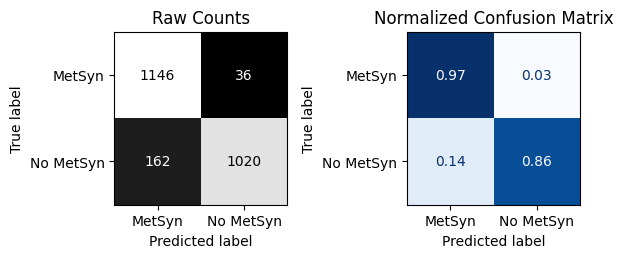


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.65      0.73      0.69       204
   No MetSyn       0.85      0.80      0.83       397

    accuracy                           0.78       601
   macro avg       0.75      0.77      0.76       601
weighted avg       0.78      0.78      0.78       601



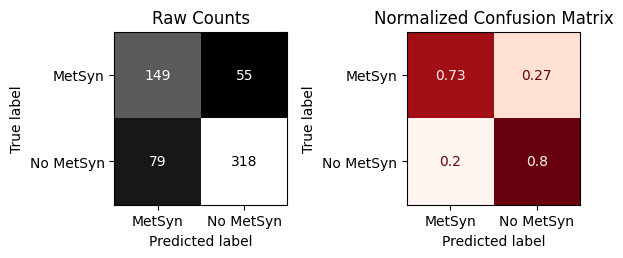

Training time was: 0:00:00.008575


In [60]:
# Import datetime library
import datetime as dt
from sklearn.neighbors import KNeighborsClassifier

# Record the start time
start = dt.datetime.now()

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train_sm, y_train_sm)

# Record the end time and calc duration
end = dt.datetime.now()
dur_baseline = end-start

evaluate_classification(knn, X_train_sm,y_train_sm, X_test_tf, y_test)
print(f'Training time was: {dur_baseline}')



In [61]:
from sklearn. inspection import permutation_importance
from sklearn. datasets import fetch_openml
from sklearn.metrics import accuracy_score

rf=RandomForestClassifier(n_estimators=77,random_state = 42)

rf.fit(X_train_tf, y_train)

#evaluate baseline performance
y_pred=rf.predict(X_train_tf)
baseline_accuracy= accuracy_score(y_train,y_pred)
print(f'Baseline Accuracy:{baseline_accuracy}')

#compute permutation importance
result=permutation_importance(rf,X_train_tf,y_train,n_repeats=10,random_state=42)

#dataframe
importance_df=pd.DataFrame({'feature':X_train_tf.columns,'importance':result.importances_mean})

#sort by importance
importance_df=importance_df.sort_values(by='importance',ascending=False)

#top 10 features
top_10_features=importance_df.head(10)
print (top_10_features)


Baseline Accuracy:1.0
          feature  importance
8    BloodGlucose    0.117389
10  Triglycerides    0.111722
3       WaistCirc    0.073889
9             HDL    0.045444
4             BMI    0.027167
1             Age    0.016444
6         UrAlbCr    0.008389
7        UricAcid    0.003500
12       Sex_Male    0.002167
0            seqn    0.001833


#marital status, race,sex,age and level of income are sociodemographic factors and directly or indirectly affect an individual's susceptability of getting metabolic syndrome.

#waist circumference,blood glucose, tryglcerides and HDL are the principal labaratory investigations in the diagnosis of metabolic syndrome however albuminuria ,uric acid and urinary albumin to creatinine ratio are predictive tests of which urinary albumin to creatinine ratio is most predictive rendering albuminuria and uric acid inferior.

#BMI too  in preference of waist circumference is a less accurate parameter of body fat distribution.

#the above scientific observations have been proven right by the machine learning tool when tested on the data to screen out the top 10 most important features.

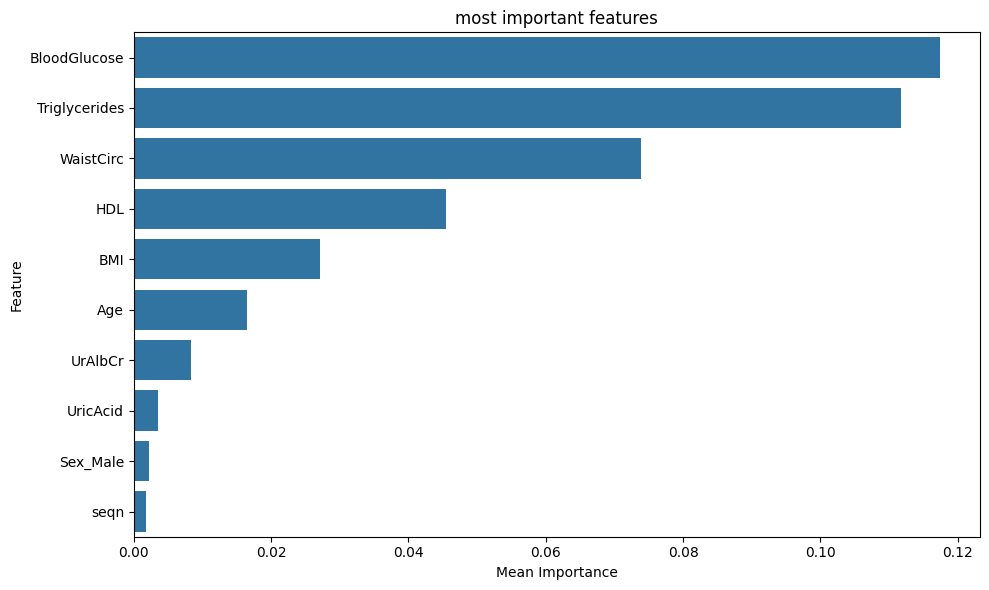

In [62]:
#visualisation of top 10 features
plt.figure(figsize=(10,6))
sns.barplot(x='importance',y='feature',data=top_10_features)
plt.title('most important features')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

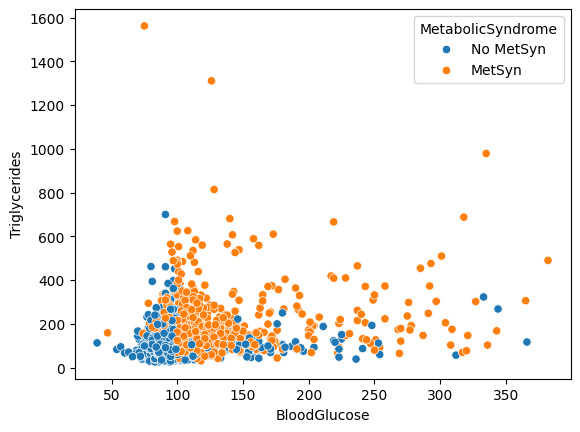

In [63]:
ax = sns.scatterplot(data=df, hue="MetabolicSyndrome", x="BloodGlucose", y='Triglycerides')


#with low glucose and triglyceride levels there is more concentration of non metabolic syndrome and as the two parameters increase we see an increase in the metabolic syndrome concentration.

#PROJECT CORE 4 pt2

In [103]:
# Part 1: Baseline model without feature engineering
baseline_model = RandomForestClassifier(random_state=42)
baseline_model.fit(X_train_tf, y_train)
y_pred_baseline = baseline_model.predict(X_test_tf)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f'Baseline Model Accuracy: {baseline_accuracy:.4f}')


Baseline Model Accuracy: 0.8852


In [104]:
# Feature Engineering Method: Polynomial Features
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_train = poly.fit_transform(X_train_tf)
poly_test = poly.transform(X_test_tf)

In [106]:
# Fit and evaluate model with polynomial features
poly_model = RandomForestClassifier(random_state=42)
poly_model.fit(poly_train, y_train)
y_pred_poly = poly_model.predict(poly_test)
poly_accuracy = accuracy_score(y_test, y_pred_poly)
print(f'Polynomial Features Model Accuracy: {poly_accuracy:.4f}')


Polynomial Features Model Accuracy: 0.8702


In [107]:
# Feature Selection using RFE
rfe_selector = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10, step=1)
rfe_selector.fit(poly_train, y_train)
X_train_rfe = rfe_selector.transform(poly_train)
X_test_rfe = rfe_selector.transform(poly_test)


In [108]:
# Fit and evaluate final model with selected features
final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_train_rfe, y_train)
y_pred_final = final_model.predict(X_test_rfe)
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f'Final Model Accuracy: {final_accuracy:.4f}')


Final Model Accuracy: 0.8669


In [109]:
# Permutation Importance
perm_importance = permutation_importance(final_model, X_test_rfe, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[-10:]


In [110]:
#compute permutation importance
result=permutation_importance(final_model,X_test_rfe,y_test,n_repeats=10,random_state=42)

#dataframe
importance_df=pd.DataFrame({'feature':X_test_rfe.columns,'importance':result.importances_mean})

#sort by importance
importance_df=importance_df.sort_values(by='importance',ascending=False)

#top 10 features
top_10_features=importance_df.head(10)
print (top_10_features)

                      feature  importance
2                BloodGlucose    0.062729
4               Triglycerides    0.041265
9              HDL Sex_Female    0.019301
0                   WaistCirc    0.018303
3                         HDL    0.006988
1                         BMI    0.004493
6        UrAlbCr BloodGlucose    0.003827
5           WaistCirc UrAlbCr   -0.001664
8  BloodGlucose Triglycerides   -0.001830
7       UrAlbCr Triglycerides   -0.006489


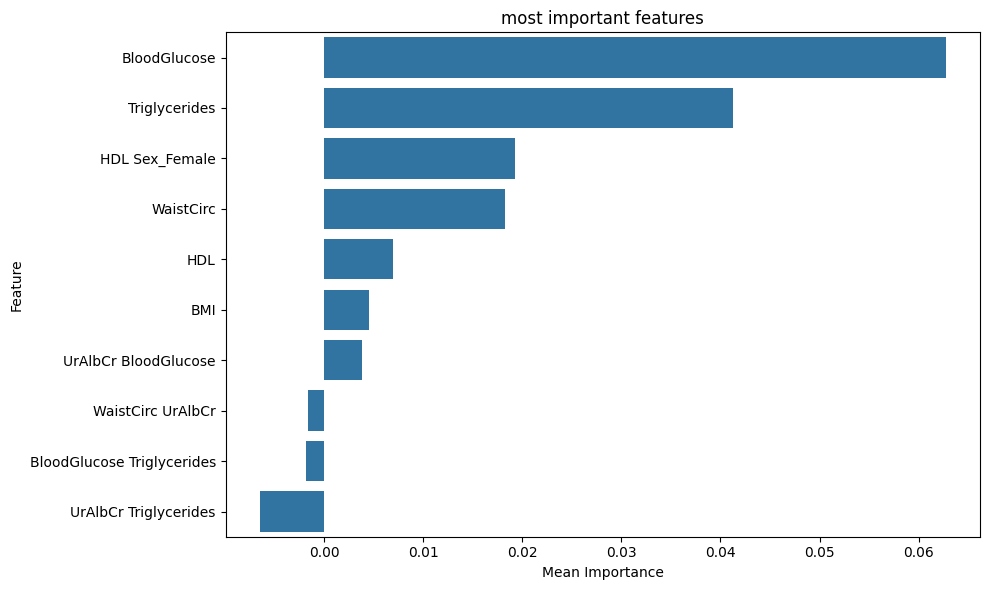

In [111]:
#visualisation of top 10 features
plt.figure(figsize=(10,6))
sns.barplot(x='importance',y='feature',data=top_10_features)
plt.title('most important features')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#model evaluation.
Baseline Model Accuracy: 0.8852
feature engineering Model Accuracy: 0.8702
Final Model Accuracy with Feature Selection: 0.8669

the column labels changed so comparison is quite hard.then with

The final model with feature selection generally shows less accuracy but was fastest